# BYOS v0.5 demo (prototype)

This notebook uses `BYOS/cfg_byos.yaml` and the local PG-19 folder.

Notes:
- Ensure `dataset_dir` in the config points to `/notebooks/PG-19`.
- The notebook will hard-error if the PG-19 folders are missing.


In [1]:
from pathlib import Path
import sys
import yaml
import torch
import os
os.environ["COMET_API_KEY"]="R7OuT6FolA02VmQRI82xDN48O"
os.environ["COMET_DISABLE_AUTO_LOGGING"]="1"

repo_root = Path("/notebooks/litgpt")

repo_root_str = str(repo_root)
if repo_root_str not in sys.path:
    sys.path.append(repo_root_str)

from BYOS.tokenizer import Tokenizer
from BYOS.byos_prototype_v0_5 import BYOSv0_5
from BYOS.byos_data import resolve_tokenizer_config, parse_h_len_cfg, sample_h_len

CFG_PATH = repo_root / "BYOS" / "cfg_byos_default.yaml"
INFERENCE = TRAIN = TOY_RUN = False

ckpt_path = "/notebooks/BYOS/state_dict/init_test_byos_v0_latest.pt"

In [2]:
cfg = yaml.safe_load(Path(CFG_PATH).read_text(encoding="utf-8")) or {}
dataset_dir = Path(cfg.get("dataset_dir", "/notebooks/PG-19"))
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "validation"

if not train_dir.is_dir():
    raise FileNotFoundError(f"Missing train dir: {train_dir}")
if not val_dir.is_dir():
    raise FileNotFoundError(f"Missing validation dir: {val_dir}")

print(f"PG-19 dataset dir OK: {dataset_dir}")


PG-19 dataset dir OK: /notebooks/PG-19


In [3]:
if TOY_RUN:
    # Toy forward pass (small, fast)
    tokenizer_cfg = resolve_tokenizer_config(cfg.get("tokenizer"))
    tokenizer = Tokenizer(tokenizer_cfg["checkpoint_dir"])

    device_cfg = cfg.get("device", "auto")
    device = torch.device("cuda" if device_cfg == "auto" and torch.cuda.is_available() else device_cfg)

    batch_size = 2
    n_local = min(64, int(cfg.get("n_local", 256)))
    h_len_cfg = parse_h_len_cfg(cfg.get("h_len", 128))
    h_len = min(sample_h_len(h_len_cfg), 64)

    d_model = int(cfg.get("d_model", 256))
    n_heads = int(cfg.get("n_heads", 4))
    n_layers = int(cfg.get("n_layers", 4))
    n_state = int(cfg.get("n_state", 16))

    model = BYOSv0_5(
        vocab_size=tokenizer.vocab_size,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        n_state=n_state,
        n_local=n_local,
    ).to(device)

    # Use a tiny dummy batch for sanity
    x_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, n_local), device=device)
    h_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, h_len), device=device)
    y_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, n_local), device=device)

    s0 = None
    if h_len == 0:
        s0 = torch.zeros(batch_size, n_state, d_model, device=device, dtype=model.tok_emb.weight.dtype)

    loss = model(x_ids, h_ids, y_ids, s0=s0)
    print("toy loss:", float(loss))


In [4]:
if TRAIN:
    # Full training run (uses BYOS/cfg_byos.yaml)
    import BYOS.byos_train as byos_train
    byos_train.main()


# INFERENCE

In [5]:
INFERENCE = True
if INFERENCE:
    prompt_len = 2048
    gen_len = 256
    temperature = 1
    top_k = 120
    routing_temp = 0.5

    import BYOS.byos_eval as byos_eval

    sys.argv = [
        "byos_eval",
        "--checkpoint",
        ckpt_path,
        "--prompt-len",
        str(prompt_len),
        "--gen-len",
        str(gen_len),
        "--temperature",
        str(temperature),
        "--top-k",
        str(top_k),
        "--routing-temp",
        str(routing_temp),
    ]

    byos_eval.main()


Source: /notebooks/PG-19/test/30312.txt
Seed: 737965401
Start idx: 115299
Prompt len: 2048 | Gen len: 256 | n_local: 1024 | routing_temp: 0.5


prefill:   0%|          | 0/1024 [00:00<?, ?it/s]

generate:   0%|          | 0/256 [00:00<?, ?it/s]

---- Prompt ----
But what must he teach Carmen in regard to the Church? Could he
maintain his position in it, yet not of it; and at the same time rear
her without its pale, yet so as not to conflict with the people of
Simiti, nor cause such comment as might reach the ears of the Bishop
of Cartagena? God alone knew. It must be attempted, at any rate. There
was no other way. And if it was God's plan, he might safely trust Him
for the requisite strength and wisdom. For this course the isolation
of Simiti and the childish simplicity of its people afforded a
tremendous advantage. On the other hand, he knew that both he and
Carmen had powerful enemies. Yet, one with God might rout a host. And
Carmen walked with God.

Thus throughout the afternoon the priest weighed and pondered the
thoughts that sought admission to his reawakened mind. He was not
interrupted until sundown; and then Carmen entered the room with a
bowl of chocolate and some small wheaten loaves. Behind her, with an
amusing sho

In [6]:
assert False

AssertionError: 

# Inspection

In [7]:
from BYOS.byos_monitor import attn_s_mass, state_update_stats, inference_monitor, inference_aging_monitor, plot_attn_series
from BYOS.byos_prototype import BYOSv1
from BYOS.byos_data import resolve_tokenizer_config
import random

tokenizer_cfg = resolve_tokenizer_config(cfg.get("tokenizer"))
tokenizer = Tokenizer(tokenizer_cfg["checkpoint_dir"])

device_cfg = cfg.get("device", "auto")
device = torch.device("cuda" if device_cfg == "auto" and torch.cuda.is_available() else device_cfg)

model = BYOSv1(
    predictor=None,
    vocab_size=tokenizer.vocab_size,
    d_model=int(cfg.get("d_model", 256)),
    n_heads=int(cfg.get("n_heads", 4)),
    n_layers=int(cfg.get("n_layers", 4)),
    n_state=int(cfg.get("n_state", 16)),
    n_local=int(cfg.get("n_local", 128)),
    label_smoothing=float(cfg.get("label_smoothing", 0.0)),
).to(device)

ckpt_path = "/notebooks/BYOS/state_dict/init_test_byos_v0_latest.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt["model"], strict=True)
model.eval()

dataset_dir = Path(cfg.get("dataset_dir", "/notebooks/PG-19"))
test_dir = dataset_dir / "test"
test_files = list(test_dir.glob("*.txt"))
if not test_files:
    raise FileNotFoundError(f"No test files in {test_dir}")


## Train

In [ ]:
num_runs = 5
for _ in range(num_runs):
    path = random.choice(test_files)
    text = path.read_text(encoding="utf-8")
    tokens = tokenizer.encode(text, device=torch.device("cpu")).to(dtype=torch.long)

    n_local = int(cfg.get("n_local", 128))
    h_len_cfg = parse_h_len_cfg(cfg.get("h_len", 128))
    h_len = sample_h_len(h_len_cfg)
    span = h_len + n_local + 1
    if tokens.numel() <= span:
        raise ValueError("not enough tokens for inspection batch")

    start = random.randint(0, tokens.numel() - span)
    h_ids = tokens[start : start + h_len].unsqueeze(0)
    x_ids = tokens[start + h_len : start + h_len + n_local].unsqueeze(0)
    y_ids = tokens[start + h_len + 1 : start + h_len + 1 + n_local].unsqueeze(0)
    batch = (h_ids, x_ids, y_ids, h_len)

    attn_metrics = attn_s_mass(model, batch, device=device)
    state_metrics = state_update_stats(model, batch, device=device)

    print("Source:", path)
    print("attn_metrics:", attn_metrics)
    print("state_metrics:", state_metrics)


Source: /notebooks/PG-19/test/37443.txt
attn_metrics: {'attn_s_mass_mean': 0.3616964506606261, 'attn_s_mass_layers': [0.2052934616804123, 0.2940714359283447, 0.4139265716075897, 0.466675341129303, 0.5172853469848633, 0.5182288289070129, 0.4974454641342163, 0.4387153387069702, 0.2867756485939026, 0.3333931863307953, 0.17789682745933533, 0.19064995646476746]}
state_metrics: {'routing_entropy': 4.553395748138428, 'routing_topk_mass': 0.013973223976790905}
Source: /notebooks/PG-19/test/55871.txt
attn_metrics: {'attn_s_mass_mean': 0.3966001781324546, 'attn_s_mass_layers': [0.21686355769634247, 0.3612724244594574, 0.4784029424190521, 0.5371450185775757, 0.5719789862632751, 0.5538641214370728, 0.5174218416213989, 0.45204100012779236, 0.2926394045352936, 0.3569676876068115, 0.19668731093406677, 0.22391784191131592]}
state_metrics: {'routing_entropy': 4.549252510070801, 'routing_topk_mass': 0.017475303262472153}
Source: /notebooks/PG-19/test/9931.txt
attn_metrics: {'attn_s_mass_mean': 0.4047298

## Inference

In [ ]:
# Inference monitoring (single prompt)
prompt_len = max(int(cfg.get("n_local", 128)) * 2, 256)
gen_len_monitor = 64

path = random.choice(test_files)
text = path.read_text(encoding="utf-8")
tokens = tokenizer.encode(text, device=torch.device("cpu")).to(dtype=torch.long)

if tokens.numel() <= prompt_len + 1:
    raise ValueError("not enough tokens for inference monitor")

num_runs = 4
for t in [0.3, 0.5, 0.7, 0.9]:
    model.predictor.routing_temp = t
    for _ in range(num_runs):    
        start = random.randint(0, tokens.numel() - (prompt_len + 1))
        prompt_ids = tokens[start : start + prompt_len]

        inf_metrics = inference_monitor(
            model,
            prompt_ids=prompt_ids,
            n_local=int(cfg.get("n_local", 128)),
            gen_len=gen_len_monitor,
            device=device,
            topk=1,
        )

        print(f"Inference monitor (mean over steps), temp: {t}")
        print({
            "attn_s_mass": sum(m["attn_s_mass"] for m in inf_metrics) / len(inf_metrics),
            "routing_entropy": sum(m["routing_entropy"] for m in inf_metrics) / len(inf_metrics),
            "routing_topk_mass": sum(m["routing_topk_mass"] for m in inf_metrics) / len(inf_metrics),
            "delta_s_norm": sum(m["delta_s_norm"] for m in inf_metrics) / len(inf_metrics),
        })
    print()


Inference monitor (mean over steps), temp: 0.3
{'attn_s_mass': 0.3671744607078532, 'routing_entropy': 3.847409099340439, 'routing_topk_mass': 0.11861331859836355, 'delta_s_norm': 0.007969881262397394}
Inference monitor (mean over steps), temp: 0.3
{'attn_s_mass': 0.3677591060404665, 'routing_entropy': 3.887544948607683, 'routing_topk_mass': 0.11171858213492669, 'delta_s_norm': 0.007708279787038919}
Inference monitor (mean over steps), temp: 0.3
{'attn_s_mass': 0.37205683191617334, 'routing_entropy': 3.8806664161384106, 'routing_topk_mass': 0.11237662902567536, 'delta_s_norm': 0.008170306107786018}
Inference monitor (mean over steps), temp: 0.3
{'attn_s_mass': 0.3672182079171762, 'routing_entropy': 3.9443353451788425, 'routing_topk_mass': 0.10661826736759394, 'delta_s_norm': 0.007837031997041777}

Inference monitor (mean over steps), temp: 0.5
{'attn_s_mass': 0.36802779205997166, 'routing_entropy': 4.155859138816595, 'routing_topk_mass': 0.09339484194060788, 'delta_s_norm': 0.0072866391

aging prefill:   0%|          | 0/1024 [00:00<?, ?it/s]

aging generate:   0%|          | 0/8192 [00:00<?, ?it/s]

---- Prompt ----
that, were you to do so in the most
remote corner of Scotland, I have ears to hear it even there, and a
hand and poniard to reach a traitor's bosom. I am--but the word will not
out!"

"Do not speak it then," said the prudent glover: "a secret is no longer
safe when it crosses the lips of him who owns it, and I desire not a
confidence so dangerous as you menace me with."

"Ay, but I must speak, and you must hear," said the youth. "In this age
of battle, father, you have yourself been a combatant?"

"Once only," replied Simon, "when the Southron assaulted the Fair City.
I was summoned to take my part in the defence, as my tenure required,
like that of other craftsmen, who are bound to keep watch and ward."

"And how felt you upon that matter?" inquired the young chief.

"What can that import to the present business?" said Simon, in some
surprise.

"Much, else I had not asked the question," answered. Eachin, in the tone
of haughtiness which from time to time he assumed.



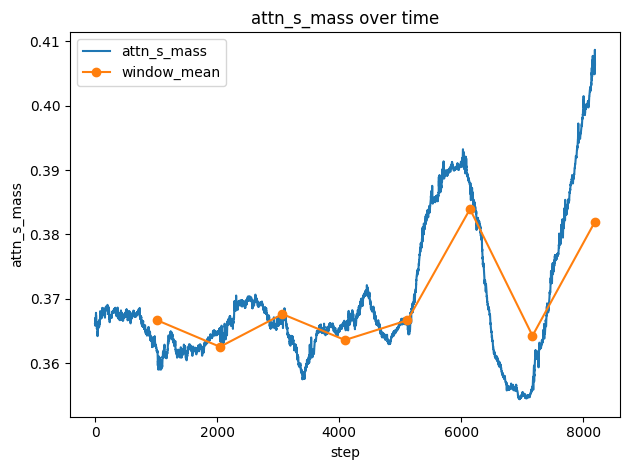

In [11]:
# Inference monitoring (single prompt)
prompt_len = max(int(cfg.get("n_local", 128)) * 2, 256)

path = random.choice(test_files)
text = path.read_text(encoding="utf-8")
tokens = tokenizer.encode(text, device=torch.device("cpu")).to(dtype=torch.long)

if tokens.numel() <= prompt_len + 1:
    raise ValueError("not enough tokens for inference monitor")

# Inference aging monitor (attn_s_mass over time)
aging_gen_len = int(cfg.get("n_local", 128)) * 8
aging_window = int(cfg.get("n_local", 128))
routing_temp = 0.5
temperature = 1.0
top_k = 120
routing_topk = 1
print_text = True
model.predictor.routing_temp = routing_temp

start = random.randint(0, tokens.numel() - (prompt_len + 1))
prompt_ids = tokens[start : start + prompt_len]

aging = inference_aging_monitor(
    model,
    prompt_ids=prompt_ids,
    n_local=int(cfg.get("n_local", 128)),
    gen_len=aging_gen_len,
    device=device,
    temperature=temperature,
    top_k=top_k,
    routing_topk=routing_topk,
    tokenizer=tokenizer,
    print_text=print_text,
    window=aging_window,
)

print("Inference aging (attn_s_mass window means):")
print(aging["window_means"])

fig, ax = plot_attn_series(aging["attn_s_mass_series"], aging["window_means"])


# dolma 

In [1]:
# Streaming sanity check: Dolma v1_6-sample
# - Requires: pip install datasets
# - Does not download the full dataset; pulls a few samples via HF streaming.

from pathlib import Path
import itertools
import statistics

import torch

try:
    from datasets import load_dataset
except Exception as exc:
    raise RuntimeError(
        "Missing dependency: datasets. Install with: pip install datasets"
    ) from exc

from BYOS.tokenizer import Tokenizer
from BYOS.byos_data import resolve_tokenizer_config

cfg_path = Path("/notebooks/litgpt/BYOS/cfg_byos_default.yaml")
import yaml
cfg = yaml.safe_load(cfg_path.read_text(encoding="utf-8")) or {}

tok_cfg = resolve_tokenizer_config(cfg.get("tokenizer"))
tokenizer = Tokenizer(tok_cfg["checkpoint_dir"])

dataset_name = "allenai/dolma"
dataset_config = "v1_6-sample"
split = "train"

print(f"Loading streaming dataset: {dataset_name} ({dataset_config}) split={split}")
ds = load_dataset(dataset_name, dataset_config, split=split, streaming=True)

# Try to find a reasonable text field.
ds_iter = iter(ds)
first = next(ds_iter)
text_key = "text" if "text" in first else next(iter(first.keys()))
print("Example keys:", list(first.keys()))
print("Using text field:", text_key)

# Small sample to verify end-to-end (stream -> text -> tokens)
num_samples = 16
texts = [first[text_key]] + [ex[text_key] for ex in itertools.islice(ds_iter, num_samples - 1)]

lengths = []
for t in texts:
    ids = tokenizer.encode(str(t), device=torch.device("cpu"))
    lengths.append(int(ids.numel()))

print(f"Encoded {len(texts)} samples")
print("token_len min/mean/max:", min(lengths), statistics.mean(lengths), max(lengths))
print("first_text_chars:", len(str(texts[0])))


RuntimeError: Missing dependency: datasets. Install with: pip install datasets